In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model


angry: 978 images
disgust: 547 images
fear: 1024 images
happy: 1586 images
neutral: 1253 images
sad: 1257 images
surprise: 831 images


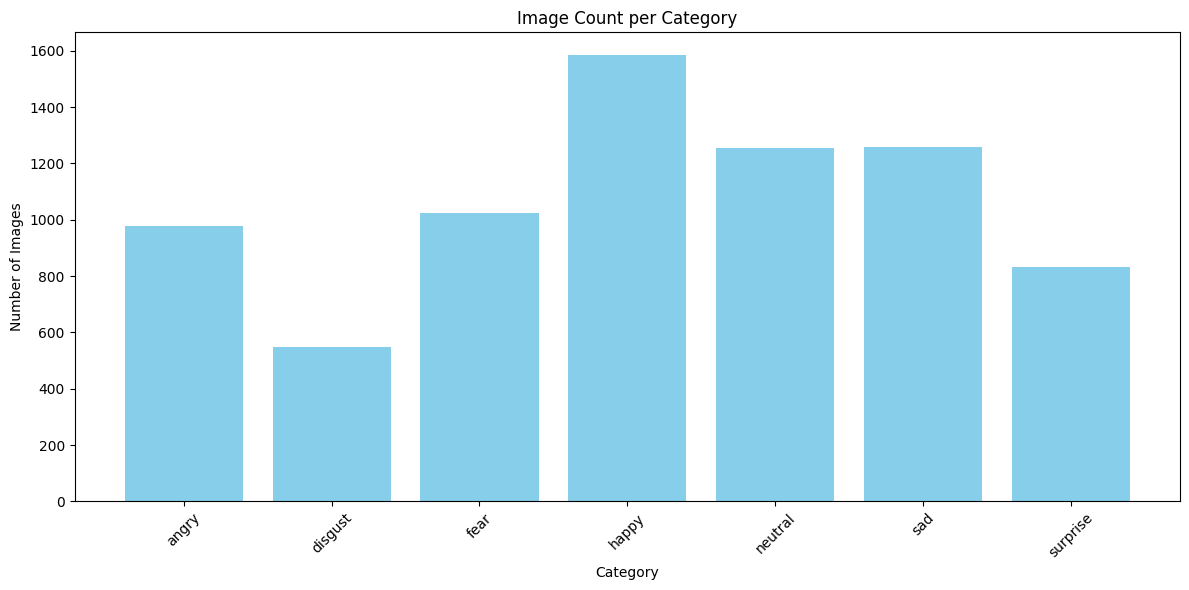

In [32]:
import os
import matplotlib.pyplot as plt

# Set dataset path
dataset_path = "/content/drive/MyDrive/Colab Notebooks/data"

# List categories
categories = sorted(os.listdir(dataset_path))
image_counts = []

# Count images in each category
for category in categories:
    category_path = os.path.join(dataset_path, category)
    image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    image_counts.append(len(image_files))
    print(f"{category}: {len(image_files)} images")

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(categories, image_counts, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Image Count per Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [33]:
#Cleaning the dataset
import os
from PIL import Image

dataset_path = "/content/drive/MyDrive/Colab Notebooks/data"
valid_extensions = ('.jpg', '.jpeg', '.png')

for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)

    if not os.path.isdir(class_dir):
        continue

    for filename in os.listdir(class_dir):
        file_path = os.path.join(class_dir, filename)

        # Check if the file has a valid image extension
        if not filename.lower().endswith(valid_extensions):
            print(f"Removing non-image file: {file_path}")
            os.remove(file_path)
            continue

        # Try opening the image to catch corrupted ones
        try:
            img = Image.open(file_path)
            img.verify()  # This will raise an exception for corrupt images
        except Exception as e:
            print(f"Removing corrupted image: {file_path} | Reason: {e}")
            os.remove(file_path)


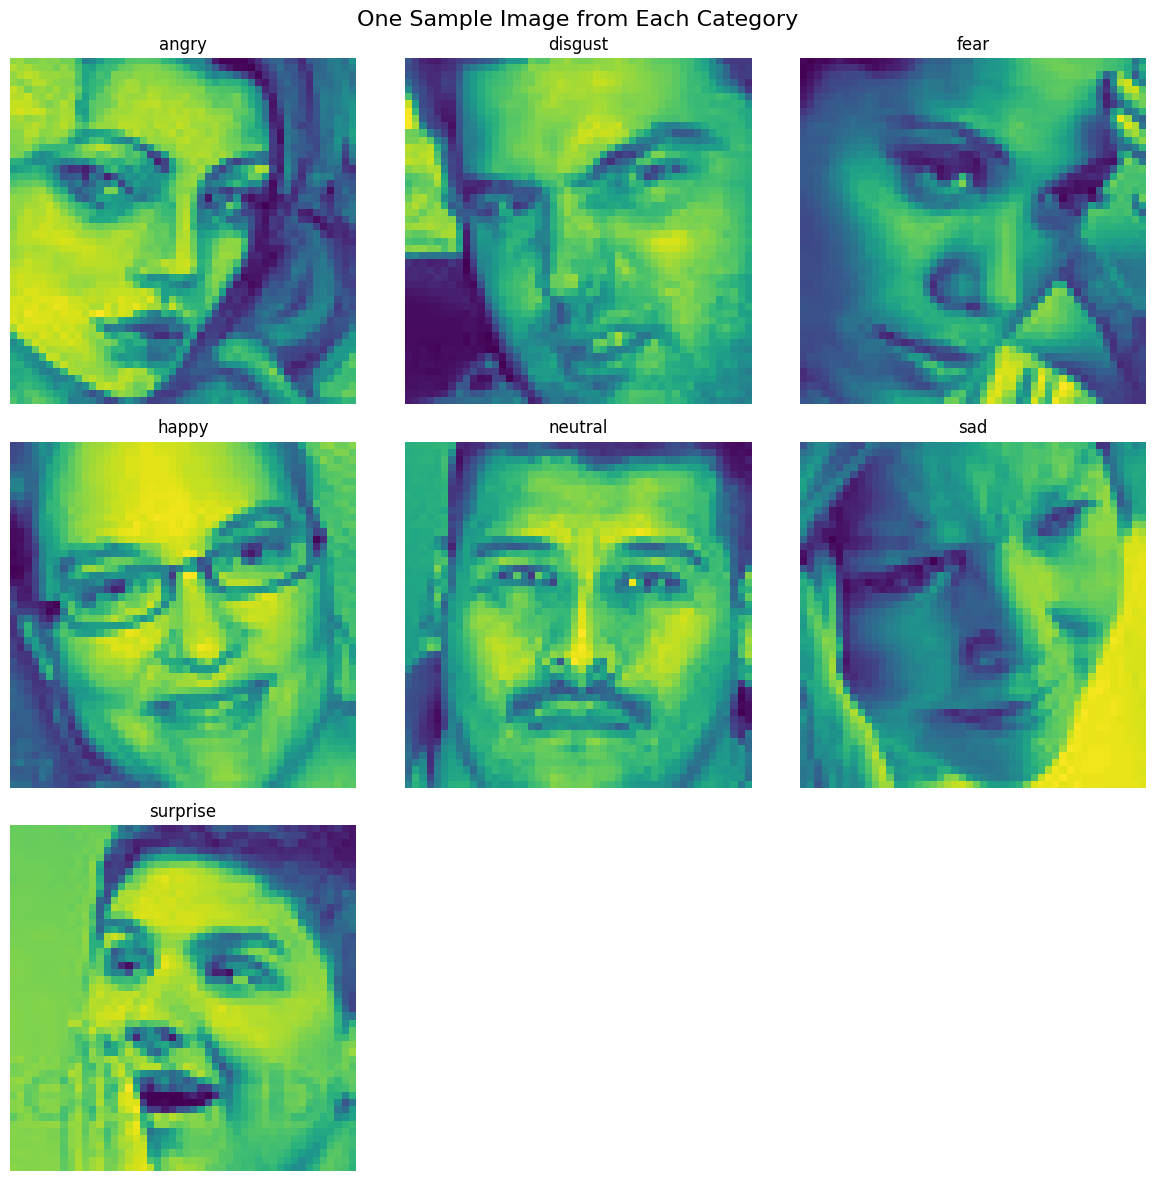

In [34]:

# List categories
categories = sorted(os.listdir(dataset_path))

# Filter categories that actually have images
valid_samples = []
for category in categories:
    category_path = os.path.join(dataset_path, category)
    image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if image_files:
        first_image_path = os.path.join(category_path, image_files[0])
        valid_samples.append((category, first_image_path))

# Plotting setup: 3 rows, auto-adjust columns
num_images = len(valid_samples)
rows = 3
cols = (num_images + rows - 1) // rows  # ceil division

plt.figure(figsize=(cols * 4, rows * 4))

for i, (category, img_path) in enumerate(valid_samples):
    img = Image.open(img_path)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(category)

plt.suptitle("One Sample Image from Each Category", fontsize=16)
plt.tight_layout()
plt.show()


In [35]:
#  Use Path object instead of string
from pathlib import Path

# Get class names (folder names)
classes = sorted(os.listdir(dataset_path))

# Initialize empty lists
images_list = []
labels_list = []

In [36]:
# Preprocessing of Image & Label List Creation

# Use Path object instead of string
from pathlib import Path

# Iterate through each class directory
for class_index, class_name in enumerate(classes):
    class_dir = Path(dataset_path) / class_name  # Use Path object for directory

    # Iterate through each image in the class directory
    for image_name in os.listdir(class_dir):
        if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):  # Check image extension
            image_path = str(class_dir / image_name) # Convert Path object back to string for image loading
            images_list.append(image_path)
            labels_list.append(class_index) # Assign class index as the label

print("Total Images:", len(images_list))
print("Total Labels:", len(labels_list))

Total Images: 7476
Total Labels: 7476


In [37]:
from PIL import Image

print("Type of images_list:", type(images_list))

# Load the first image using PIL to get its shape

image = Image.open(images_list[0])
print("Shape of image in images_list:", image.size) # Print the size (width, height)
print("Type of image in images_list:", type(images_list[0]))

Type of images_list: <class 'list'>
Shape of image in images_list: (48, 48)
Type of image in images_list: <class 'str'>


In [38]:

#Preprocessing of Image & Label List Convertion to NumPy Arrays
images_list = np.array(images_list)
labels_list = np.array(labels_list)

In [39]:
#Split Data to Train, Test & Validation
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(images_list, labels_list, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("X_val:", X_val.shape)
print("Pixel values of the first pixel (RGB) of image (BEFORE NORMALIZATION):", X_train[0][0][0])


X_train: (5233,)
X_test: (1122,)
X_val: (1121,)
Pixel values of the first pixel (RGB) of image (BEFORE NORMALIZATION): /


In [40]:


#Normalization
def normalize_image(image_path):
    img = Image.open(image_path)
    img_array = np.array(img)
    # Normalize pixel values to the range [0, 1]
    normalized_img = img_array / 255.0
    return normalized_img

# Example of how to use normalize_image function.
X_train_normalized = np.array([normalize_image(image_path) for image_path in X_train])
X_val_normalized = np.array([normalize_image(image_path) for image_path in X_val])
X_test_normalized = np.array([normalize_image(image_path) for image_path in X_test])

print("Shape of normalized X_train:", X_train_normalized.shape)
print("Pixel values of the first pixel (RGB) of image (AFTER NORMALIZATION):", X_train_normalized[0][0][0])


Shape of normalized X_train: (5233, 48, 48)
Pixel values of the first pixel (RGB) of image (AFTER NORMALIZATION): 0.43529411764705883


In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator for training
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values
    rotation_range=30,
    shear_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2         # Split for validation
)

# Train generator
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    batch_size=16,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    batch_size=16,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)


Found 5984 images belonging to 7 classes.
Found 1492 images belonging to 7 classes.


(64, 64, 3)


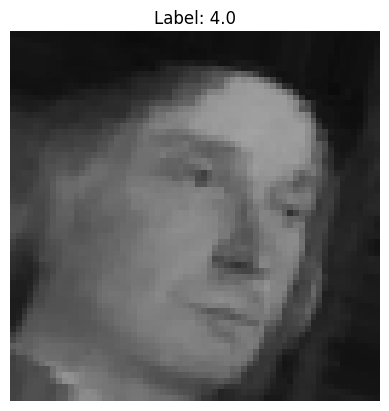

In [42]:
# Take the first image batch and the labels from train generator
images_batch, labels_batch = next(train_generator)
# Take the first image from the batch
image_to_preview = images_batch[0]

print(image_to_preview.shape)
# Display the image
plt.imshow(image_to_preview)
plt.title(f"Label: {labels_batch[0]}")
plt.axis('off')
plt.show()


In [43]:
#Callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
early_stopping = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)


In [44]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)


**EmotiNet CNN **

In [45]:
# prompt: build code for emotiNet cnn model

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os # Import the 'os' module



# Define the model architecture
model = Sequential()

dataset_path = "/content/drive/MyDrive/Colab Notebooks/data"  # Replace with your dataset path
categories = sorted(os.listdir(dataset_path))


model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3))) # Input shape adjusted for color images
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(len(categories), activation='softmax'))  # Output layer with softmax


# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [46]:
# Data augmentation for the test set (if needed)
test_augmentations = ImageDataGenerator(rescale=1./255)


# --- Define train_generator and val_generator here ---
# Define the ImageDataGenerator for training
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values
    rotation_range=30,
    shear_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2         # Split for validation
)

# Train generator
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    batch_size=16,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    batch_size=16,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)
# --- End of train_generator and val_generator definition ---



Found 5984 images belonging to 7 classes.
Found 1492 images belonging to 7 classes.


In [47]:
#Callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
early_stopping = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,  # You might need to adjust the number of epochs
    validation_data=val_generator,
    callbacks=[early_stopping, lr_scheduler]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 81s 209ms/step - accuracy: 0.1874 - loss: 1.9207 - val_accuracy: 0.2125 - val_loss: 1.9000 - learning_rate: 0.0010
Epoch 2/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 86s 230ms/step - accuracy: 0.2144 - loss: 1.8985 - val_accuracy: 0.2306 - val_loss: 1.8829 - learning_rate: 0.0010
Epoch 3/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 78s 207ms/step - accuracy: 0.2313 - loss: 1.8834 - val_accuracy: 0.2353 - val_loss: 1.8456 - learning_rate: 0.0010
Epoch 4/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 76s 202ms/step - accuracy: 0.2399 - loss: 1.8618 - val_accuracy: 0.2265 - val_loss: 1.8345 - learning_rate: 0.0010
Epoch 5/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 76s 202ms/step - accuracy: 0.2366 - loss: 1.8519 - val_accuracy: 0.2433 - val_loss: 1.8191 - learning_rate: 0.0010
Epoch 6/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 96s 240ms/step - accuracy: 0.2455 - loss: 1.8334 - val_accuracy: 0.2580 - val_loss: 1.8119 - learning_rate: 0.0010
Epoch 7/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 76s 203ms/step - accuracy: 0.2

In [48]:
# prompt: build classification report

import numpy as np
# Evaluate the model on the test set
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print the classification report
print(classification_report(val_generator.classes, y_pred_classes, target_names=categories))


94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step
              precision    recall  f1-score   support

       angry       0.41      0.15      0.22       195
     disgust       0.41      0.29      0.34       109
        fear       0.28      0.14      0.19       204
       happy       0.46      0.83      0.59       317
     neutral       0.37      0.38      0.37       250
         sad       0.34      0.30      0.32       251
    surprise       0.57      0.60      0.59       166

    accuracy                           0.42      1492
   macro avg       0.40      0.39      0.37      1492
weighted avg       0.40      0.42      0.39      1492



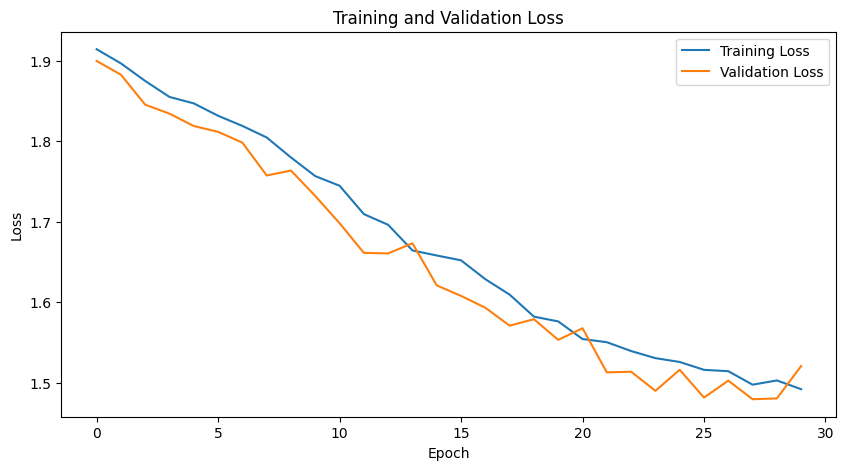

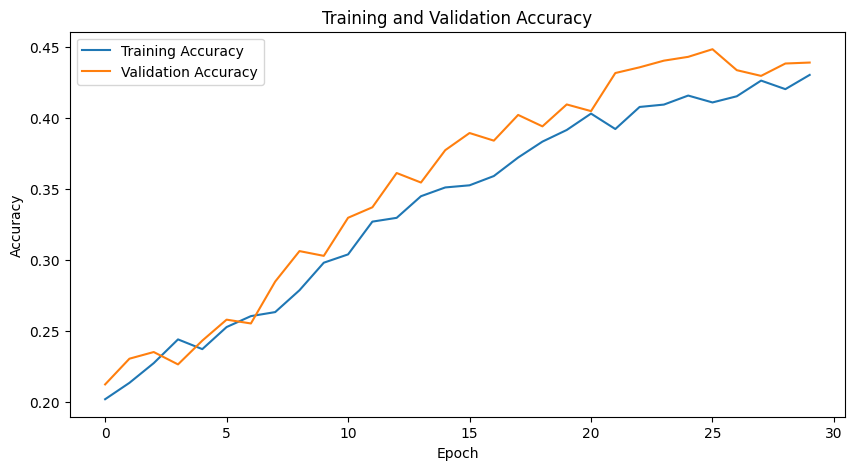

In [49]:
# prompt: #Plot Loss and Accuracy Curves

import matplotlib.pyplot as plt
# Plot the training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


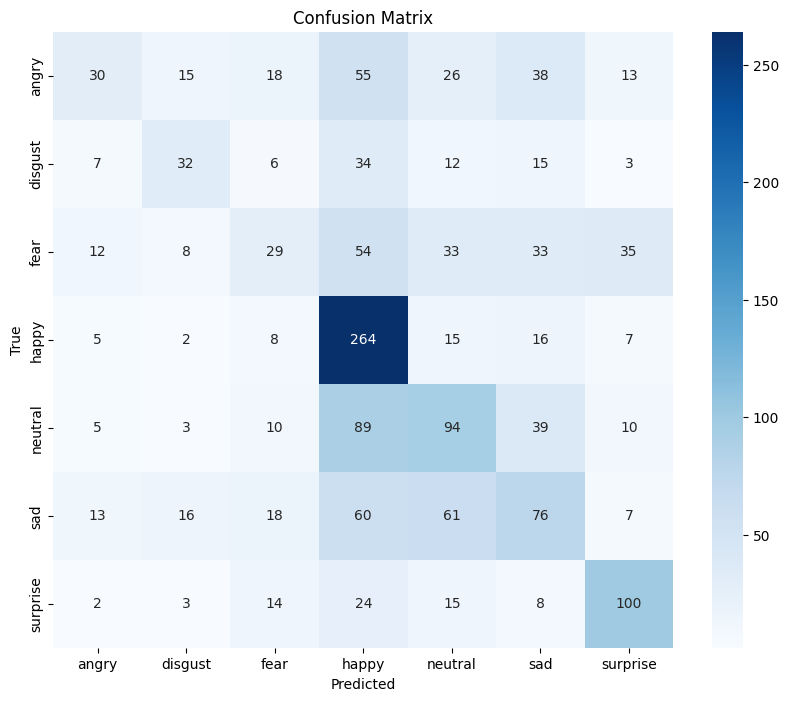

In [50]:
# prompt: #Confusion Matrix

import matplotlib.pyplot as plt
# Assuming y_true contains the true labels and y_pred_classes contains the predicted classes
cm = confusion_matrix(val_generator.classes, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


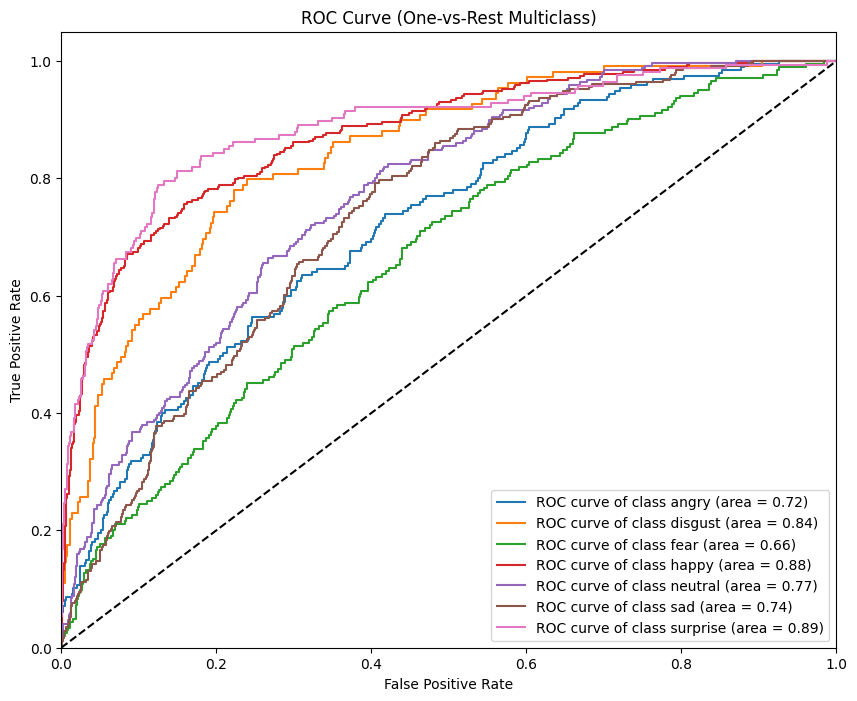

In [51]:
# prompt: # ROC Curve (One-vs-Rest for Multiclass)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize

# Binarize the output labels
y_true_binarized = label_binarize(val_generator.classes, classes=np.arange(len(categories)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(categories)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(len(categories)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {categories[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest Multiclass)')
plt.legend(loc="lower right")
plt.show()
